In [1]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

Super Quick Intro into Recurrent Neural Networks

The main difference from "ordinary" neural networks, there are back-going connections, those manifests as memory - the output of the network depends on current input **AND PAST INPUTS**.

The best known recurrent architecture is called *Long Short-Term Memory* (or LSTM for short).

The architecture is shown below.

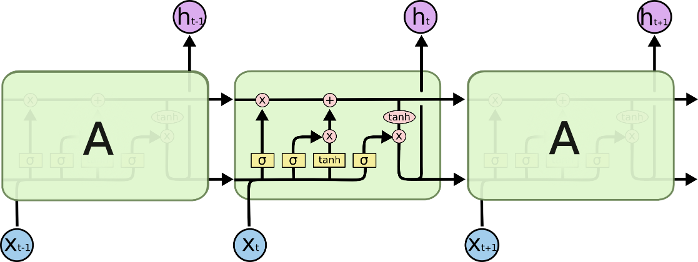

For the tutorial we will start with a simpler architecture - closely resembling Elmann network.

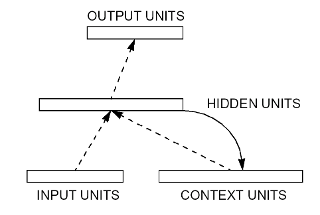

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed for sequence prediction problems. In this tutorial, we'll learn how to forecast a fading sin wave using RNNs in PyTorch. Instead of using the built-in RNN module, we'll manually implement recurrence using `nn.Linear`.

An RNN operates over sequences. For each element in a sequence, it maintains a hidden state $h_t$ that is updated using both the current input $x_t$ and the previous hidden state $h_{t-1}$. The hidden state can be seen as the memory of the RNN, capturing information about the past states of the sequence.

The update equations for an RNN are:

$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$

$
y_t = W_{hy} h_t + b_y
$

Where:
- $W_{xh}$ is the weight matrix for input to hidden layer
- $W_{hh}$ is the weight matrix for hidden layer to itself (recurrent connection)
- $W_{hy}$ is the weight matrix for hidden to output layer
- $b_h$ and $b_y$ are bias terms

In [2]:
def generate_wave(length, p = 8):
    x = np.linspace(0, p * np.pi, length)
    y = np.sin(x) * np.exp(-0.1 * x)
    return y

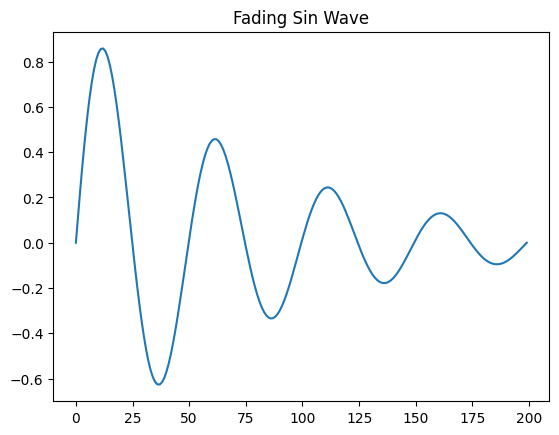

In [3]:
data = generate_wave(200, p = 8)
plt.plot(data)
plt.title("Fading Sin Wave")
plt.show()

In [4]:
# rnn = nn.RNN(10, 20, 2)
# input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# output, hn = rnn(input, h0)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()

        self.input_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.zeros(x.size(0), self.hidden_hidden.out_features).to(x.device)

        # Manually loop over sequence
        for t in range(x.size(1)):
            h = F.tanh(self.input_hidden(x[:, t, :]) + self.hidden_hidden(h))

        out = self.hidden_output(h)
        return out

In [6]:
# Convert to tensor and reshape for sequence modeling
data_tensor = torch.tensor(data).float().view(-1, 1, 1) # shape: (sequence_length, batch_size, input_dim)

seq_length = 100
inputs = [data_tensor[i:i+seq_length] for i in range(data_tensor.shape[0] - seq_length)]
targets = [data_tensor[i+1:i+seq_length+1] for i in range(data_tensor.shape[0] - seq_length)]

In [7]:
# Parameters
hidden_dim = 128
input_dim = 1
output_dim = 1
learning_rate = 0.0001
num_epochs = 50

# Create model, loss, and optimizer
model = RNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
losses = []

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(zip(inputs, targets)):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0035
Epoch 2/50, Loss: 0.0010
Epoch 3/50, Loss: 0.0004
Epoch 4/50, Loss: 0.0003
Epoch 5/50, Loss: 0.0002
Epoch 6/50, Loss: 0.0002
Epoch 7/50, Loss: 0.0002
Epoch 8/50, Loss: 0.0003
Epoch 9/50, Loss: 0.0003
Epoch 10/50, Loss: 0.0003
Epoch 11/50, Loss: 0.0003
Epoch 12/50, Loss: 0.0002
Epoch 13/50, Loss: 0.0002
Epoch 14/50, Loss: 0.0002
Epoch 15/50, Loss: 0.0002
Epoch 16/50, Loss: 0.0002
Epoch 17/50, Loss: 0.0002
Epoch 18/50, Loss: 0.0002
Epoch 19/50, Loss: 0.0002
Epoch 20/50, Loss: 0.0002
Epoch 21/50, Loss: 0.0002
Epoch 22/50, Loss: 0.0002
Epoch 23/50, Loss: 0.0002
Epoch 24/50, Loss: 0.0002
Epoch 25/50, Loss: 0.0002
Epoch 26/50, Loss: 0.0002
Epoch 27/50, Loss: 0.0002
Epoch 28/50, Loss: 0.0002
Epoch 29/50, Loss: 0.0002
Epoch 30/50, Loss: 0.0002
Epoch 31/50, Loss: 0.0002
Epoch 32/50, Loss: 0.0002
Epoch 33/50, Loss: 0.0002
Epoch 34/50, Loss: 0.0002
Epoch 35/50, Loss: 0.0002
Epoch 36/50, Loss: 0.0002
Epoch 37/50, Loss: 0.0002
Epoch 38/50, Loss: 0.0002
Epoch 39/50, Loss: 0.

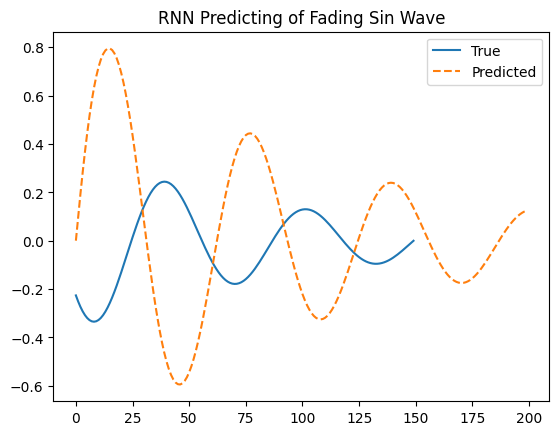

In [8]:
model.eval()
test_data = generate_wave(250)
test_data_tensor = torch.tensor(test_data).float().view(-1, 1, 1)

predictions = []

# Forecasting
for i in range(0, test_data_tensor.size(0) - seq_length, seq_length):
    seq = test_data_tensor[i:i+seq_length]
    with torch.no_grad():
        predicted = model(seq)
        predictions.append(predicted)

# Convert predictions to numpy for plotting
predictions = np.concatenate([p.numpy() for p in predictions])

# Plot
plt.plot(test_data[seq_length:], label='True')
plt.plot(predictions, label='Predicted', linestyle='dashed')
plt.legend()
plt.title("RNN Predicting of Fading Sin Wave")
plt.show()

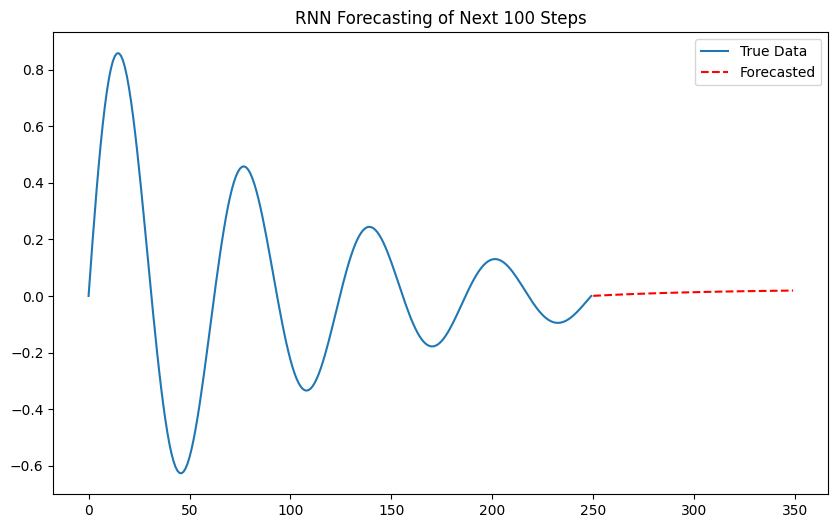

In [9]:
model.eval()

# We'll start by using the last 'seq_length' points from our original data as the initial sequence
initial_sequence = test_data_tensor[-seq_length:]  # Ensure it has a shape of (seq_length, 1, 1)

forecasts = []

for i in range(100):  # forecast the next 100 steps
    with torch.no_grad():
        # Forecast the next step based on 'initial_sequence'
        next_step_forecast = model(initial_sequence)

        # Append this forecast to our list of forecasts
        forecasts.append(next_step_forecast[-1, 0].item())

        # Create a new sequence where we remove the oldest value in 'initial_sequence' and append the forecast
        new_val = torch.tensor([[[forecasts[-1]]]]).float()
        initial_sequence = torch.cat((initial_sequence[1:], new_val), dim=0)

# Convert forecasts to numpy for plotting
forecasts = np.array(forecasts)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(test_data)), test_data, label='True Data')
plt.plot(np.arange(len(test_data), len(test_data)+100), forecasts, label='Forecasted', linestyle='dashed', color='red')
plt.legend()
plt.title("RNN Forecasting of Next 100 Steps")
plt.show()

# LSTM Cell

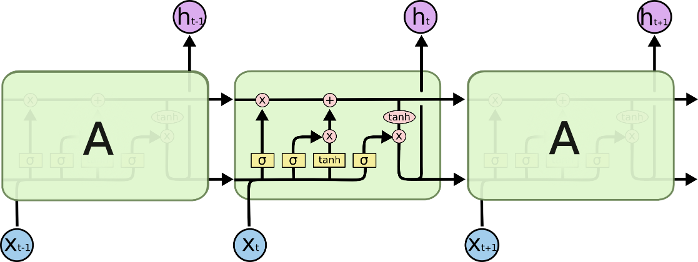

To convert the RNN to LSTM, we need to understand the underlying mathematics of the LSTM cell.

An LSTM cell is essentially a collection of gates: the input gate, the forget gate, the output gate, and a cell state. The LSTM equations are:

1. $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $  - Forget gate
2. $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $  - Input gate
3. $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $ - New candidate values
4. $C_t = f_t \times C_{t-1} + i_t \times \tilde{C}_t $ - Update cell state
5. $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $ - Output gate
6. $h_t = o_t \times \tanh(C_t) $ - Update hidden state

In [10]:
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()

        # Define the input gate
        self.input_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)

        # Define the forget gate
        self.forget_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)

        # Define the new candidate values
        self.new_candidates = nn.Linear(input_dim + hidden_dim, hidden_dim)

        # Define the output gate
        self.output_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)

        # Linear layer for final output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Batch size
        batch_size = x.size(0)

        # Initialize hidden state and cell state
        h = torch.zeros(batch_size, self.input_gate.out_features).to(x.device)
        c = torch.zeros(batch_size, self.input_gate.out_features).to(x.device)

        # Loop over sequence
        for t in range(x.size(1)):
            combined = torch.cat((h, x[:, t, :]), dim=1)

            # Forget gate
            f_t = torch.sigmoid(self.forget_gate(combined))

            # Input gate
            i_t = torch.sigmoid(self.input_gate(combined))

            # New candidate values
            new_c_t = torch.tanh(self.new_candidates(combined))

            # Update cell state
            c = f_t * c + i_t * new_c_t

            # Output gate
            o_t = torch.sigmoid(self.output_gate(combined))

            # Update hidden state
            h = o_t * torch.tanh(c)

        out = self.fc(h)
        return out

In [11]:
# Parameters
hidden_dim = 32
input_dim = 1
output_dim = 1
learning_rate = 0.01
num_epochs = 50

# Create model, loss, and optimizer
model = LSTM(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
losses = []

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(zip(inputs, targets)):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0003
Epoch 2/50, Loss: 0.0002
Epoch 3/50, Loss: 0.0002
Epoch 4/50, Loss: 0.0002
Epoch 5/50, Loss: 0.0002
Epoch 6/50, Loss: 0.0002
Epoch 7/50, Loss: 0.0002
Epoch 8/50, Loss: 0.0002
Epoch 9/50, Loss: 0.0002
Epoch 10/50, Loss: 0.0002
Epoch 11/50, Loss: 0.0002
Epoch 12/50, Loss: 0.0002
Epoch 13/50, Loss: 0.0003
Epoch 14/50, Loss: 0.0003
Epoch 15/50, Loss: 0.0003
Epoch 16/50, Loss: 0.0003
Epoch 17/50, Loss: 0.0003
Epoch 18/50, Loss: 0.0003
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0003
Epoch 21/50, Loss: 0.0003
Epoch 22/50, Loss: 0.0003
Epoch 23/50, Loss: 0.0003
Epoch 24/50, Loss: 0.0003
Epoch 25/50, Loss: 0.0003
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0003
Epoch 28/50, Loss: 0.0003
Epoch 29/50, Loss: 0.0003
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0002
Epoch 36/50, Loss: 0.0002
Epoch 37/50, Loss: 0.0002
Epoch 38/50, Loss: 0.0002
Epoch 39/50, Loss: 0.

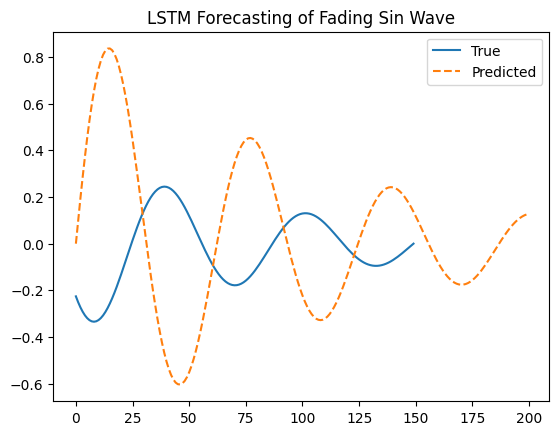

In [12]:
model.eval()
test_data = generate_wave(250)
test_data_tensor = torch.tensor(test_data).float().view(-1, 1, 1)

predictions = []

# Forecasting
for i in range(0, test_data_tensor.size(0) - seq_length, seq_length):
    seq = test_data_tensor[i:i+seq_length]
    with torch.no_grad():
        predicted = model(seq)
        predictions.append(predicted)

# Convert predictions to numpy for plotting
predictions = np.concatenate([p.numpy() for p in predictions])

# Plot
plt.plot(test_data[seq_length:], label='True')
plt.plot(predictions, label='Predicted', linestyle='dashed')
plt.legend()
plt.title("LSTM Forecasting of Fading Sin Wave")
plt.show()

In [13]:
model.eval()

# We'll start by using the last 'seq_length' points from our original data as the initial sequence
initial_sequence = test_data_tensor[-seq_length:]

forecasts = []

for i in range(100):  # forecast the next 100 steps
    with torch.no_grad():
        # Forecast the next step based on 'initial_sequence'
        next_step_forecast = model(initial_sequence)

        # Append this forecast to our list of forecasts
        forecasts.append(next_step_forecast[-1, 0].item())

        # Create a new sequence where we remove the oldest value in 'initial_sequence' and append the forecast
        new_val = torch.tensor([[[forecasts[-1]]]]).float()
        initial_sequence = torch.cat((initial_sequence[1:], new_val), dim=0)

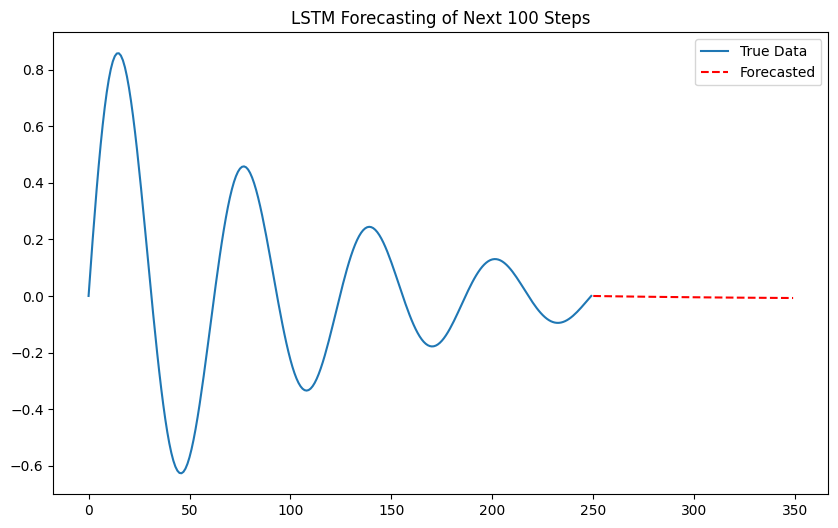

In [14]:
# Convert forecasts to numpy for plotting
forecasts = np.array(forecasts)


plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(test_data)), test_data, label='True Data')
plt.plot(np.arange(len(test_data), len(test_data)+100), forecasts, label='Forecasted', linestyle='dashed', color='red')
plt.legend()
plt.title("LSTM Forecasting of Next 100 Steps")
plt.show()

# ⚠️⚠️⚠️ Homework ⚠️⚠️⚠️

* Now when you know many various tricks on how to build a better architecture (regularization, stacking layers, schedulers, optimizers) try to build a model that forecasts fading sine properly! 💪
You can use GRU or LSTM pre-defined cells from `torch.nn`
Use `nn.Linear` or `torch.tensor` for extra points!

In [15]:
import torch.optim as optim

# Define the model
class SineFadingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SineFadingModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

In [16]:
# data
input_size = 1
hidden_size = 32
output_size = 1
num_steps = 100

model = SineFadingModel(input_size, hidden_size, output_size)

optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()


In [17]:
# training
for epoch in range(1000):
    hidden = model.init_hidden()
    loss = 0
    for i in range(num_steps):
        #input = torch.tensor([[torch.sin(i / 10)]])
        input = torch.tensor([[torch.sin(torch.tensor(i / 10))]]) # Convert i / 10 to a tensor before passing to torch.sin()

        target = torch.tensor([[torch.sin(torch.tensor(i+1 / 10))]])
        output, hidden = model(input, hidden)
        loss += loss_function(output, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 50.534637451171875
Epoch: 100 Loss: 49.86402893066406
Epoch: 200 Loss: 3.16424822807312
Epoch: 300 Loss: 0.3115670382976532
Epoch: 400 Loss: 0.20500676333904266
Epoch: 500 Loss: 0.14569658041000366
Epoch: 600 Loss: 0.11374888569116592
Epoch: 700 Loss: 0.09223874658346176
Epoch: 800 Loss: 0.31537237763404846
Epoch: 900 Loss: 0.06789267808198929


In [18]:
# evaluation
hidden = model.init_hidden()
for i in range(num_steps):
    input = torch.tensor([[torch.sin(torch.tensor(i / 10))]])
    output, hidden = model(input, hidden)
    print('Input:', input.item(), 'Output:', output.item())

Input: 0.0 Output: 0.31171804666519165
Input: 0.0998334214091301 Output: 0.836746096611023
Input: 0.19866932928562164 Output: 0.7989252805709839
Input: 0.29552021622657776 Output: 0.042684540152549744
Input: 0.389418363571167 Output: -0.7884130477905273
Input: 0.4794255495071411 Output: -0.901751697063446
Input: 0.5646424889564514 Output: -0.17282195389270782
Input: 0.6442176699638367 Output: 0.7111949920654297
Input: 0.7173560857772827 Output: 0.9660335779190063
Input: 0.7833268642425537 Output: 0.3274953365325928
Input: 0.8414709568023682 Output: -0.6217416524887085
Input: 0.8912073969841003 Output: -0.9915305376052856
Input: 0.9320390820503235 Output: -0.44343191385269165
Input: 0.9635581970214844 Output: 0.4988643527030945
Input: 0.9854497313499451 Output: 1.0004686117172241
Input: 0.9974949955940247 Output: 0.5786013603210449
Input: 0.9995735883712769 Output: -0.37416553497314453
Input: 0.9916648268699646 Output: -0.973697304725647
Input: 0.9738476276397705 Output: -0.680019676685

## Character-wise language model

<cite>Highly inspired by the official PyTorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html</cite>

In [19]:
from io import BytesIO
from urllib.request import urlopen

import zipfile
from io import open
import glob
import os
import unicodedata
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import torch
import math

In [20]:
resp = urlopen("https://download.pytorch.org/tutorial/data.zip")
with zipfile.ZipFile(BytesIO(resp.read())) as zip_ref:
  zip_ref.extractall('/content/')



In [21]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [22]:
def findFiles(path): return glob.glob(path)

In [23]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [24]:
# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [25]:
findFiles('data/names/*.txt')

['data/names/German.txt',
 'data/names/Russian.txt',
 'data/names/Portuguese.txt',
 'data/names/Spanish.txt',
 'data/names/Greek.txt',
 'data/names/Arabic.txt',
 'data/names/Dutch.txt',
 'data/names/Korean.txt',
 'data/names/Czech.txt',
 'data/names/English.txt',
 'data/names/Chinese.txt',
 'data/names/Vietnamese.txt',
 'data/names/Irish.txt',
 'data/names/Italian.txt',
 'data/names/Japanese.txt',
 'data/names/Scottish.txt',
 'data/names/Polish.txt',
 'data/names/French.txt']

In [26]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [27]:
n_categories = len(all_categories)

In [28]:
all_categories

['German',
 'Russian',
 'Portuguese',
 'Spanish',
 'Greek',
 'Arabic',
 'Dutch',
 'Korean',
 'Czech',
 'English',
 'Chinese',
 'Vietnamese',
 'Irish',
 'Italian',
 'Japanese',
 'Scottish',
 'Polish',
 'French']

In [29]:
print(unicodeToAscii("Čtvrtečník"))

Ctvrtecnik


In [30]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [31]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [32]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [33]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [34]:
def train(category_tensor, input_line_tensor, target_line_tensor, model):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [35]:
model = RNN(n_letters, 128, n_letters)

In [36]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

In [37]:
n_iters = 300000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample(), model)
    total_loss += loss

    if iter % print_every == 0:
        print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

(5000 1%) 2.9162
(10000 3%) 2.4153
(15000 5%) 2.6050
(20000 6%) 2.8077
(25000 8%) 2.4891
(30000 10%) 2.8987
(35000 11%) 2.5859
(40000 13%) 2.2775
(45000 15%) 1.7869
(50000 16%) 2.5701
(55000 18%) 1.8581
(60000 20%) 1.5040
(65000 21%) 1.3812
(70000 23%) 2.8395
(75000 25%) 2.4466
(80000 26%) 2.2616
(85000 28%) 2.9399
(90000 30%) 2.7461
(95000 31%) 1.3364
(100000 33%) 2.0544
(105000 35%) 2.5608
(110000 36%) 2.1993
(115000 38%) 2.7823
(120000 40%) 1.4706
(125000 41%) 1.6782
(130000 43%) 3.1721
(135000 45%) 1.9419
(140000 46%) 2.5837
(145000 48%) 2.0633
(150000 50%) 2.1136
(155000 51%) 2.2791
(160000 53%) 2.1093
(165000 55%) 2.3855
(170000 56%) 1.7344
(175000 58%) 2.1628
(180000 60%) 1.9569
(185000 61%) 2.7242
(190000 63%) 2.6516
(195000 65%) 3.3299
(200000 66%) 2.3901
(205000 68%) 1.9222
(210000 70%) 0.9892
(215000 71%) 1.9833
(220000 73%) 2.6669
(225000 75%) 1.2672
(230000 76%) 2.7463
(235000 78%) 2.2806
(240000 80%) 1.0695
(245000 81%) 2.1488
(250000 83%) 1.9034
(255000 85%) 2.1903
(2600

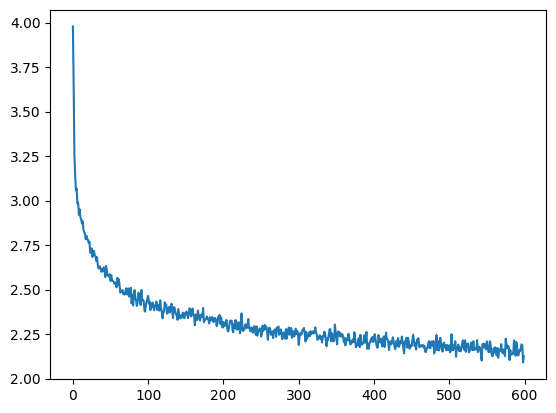

In [38]:
plt.plot(all_losses)

In [39]:
from torch.nn.modules.container import ModuleList
max_length = 50

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [40]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [41]:
all_categories

['German',
 'Russian',
 'Portuguese',
 'Spanish',
 'Greek',
 'Arabic',
 'Dutch',
 'Korean',
 'Czech',
 'English',
 'Chinese',
 'Vietnamese',
 'Irish',
 'Italian',
 'Japanese',
 'Scottish',
 'Polish',
 'French']

In [42]:
samples(category='Greek', start_letters='AVLASDFGH')

Alasanioulous
Varista
Leristis
Antoulo
Salosanoulos
Dongalopoulos
Forisou
Goristis
Haristi


# Word2Vec

Skip-gram is a model architecture for computing vector representations of words, which is part of the Word2Vec suite of models. It was created by a team of researchers led by Tomas Mikolov. The Skip-gram model is designed to predict the context words (surrounding words) for a given target word, which is the opposite of another Word2Vec architecture called Continuous Bag of Words (CBOW), which predicts a target word based on context words.

Here's a brief overview of how the Skip-gram model works:

1. **Input**: The input to the model is a word, represented as a one-hot encoded vector if the vocabulary size is V, meaning the vector is of size V with all zeros except for a one at the index corresponding to the input word.

2. **Projection**: The one-hot vector is multiplied by a weight matrix (the embedding matrix) to produce a dense vector representation of the input word. This step is essentially a lookup operation that retrieves the embedding of the input word.

3. **Prediction**: The model then uses this dense vector to predict words within a certain range before and after the input word in the sentence. This range is determined by a parameter called the "window size."

4. **Output**: The output of the model is a set of probabilities, one for each word in the vocabulary. These probabilities estimate the likelihood of each vocabulary word being in the context of the input word.

5. **Objective Function**: The training objective of the Skip-gram model is to maximize the probability of the context words given the current target word. In practice, this is often done using techniques like negative sampling or hierarchical softmax to make the computation more efficient, as computing the probabilities over a large vocabulary for each training instance can be very computationally expensive.

6. **Result**: After training, each word in the vocabulary has a corresponding dense vector which captures its semantic properties. Words that are used in similar contexts tend to have similar vectors, meaning that the vectors capture some aspects of word meaning and usage.

The Skip-gram model is particularly effective with large datasets and can capture complex word relationships, such as analogies (e.g., "man" is to "woman" as "king" is to "queen"). It also performs well with infrequent words because it treats each context-target pair as a new observation.

In [43]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [44]:
corpus = """
the quick brown fox jumps over the lazy dog
"""

In [45]:
# tokenizer function, to split the text up into smaller units (words?)
def tokenizer(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [46]:
tokens = tokenizer(corpus)

In [47]:
tokens

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [48]:
# create a map between tokens and indices
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

In [49]:
word_to_id, id_to_word = mapping(tokens)

In [50]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [51]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [52]:
def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i),
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))

    return np.asarray(X), np.asarray(y)

In [53]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [54]:
# initialize neural network
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [55]:
model = init_network(len(word_to_id), 16)

In [56]:
len(word_to_id)

8

In [57]:
def forward(model, X, return_cache=True):
    cache = {}

    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])

    if not return_cache:
        return cache["z"]
    return cache

In [58]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [59]:
def cross_entropy(yhat, y):
    return - np.sum(np.log(yhat) * y)

In [60]:
def nll_loss(yhat, y):
    return -(y * yhat.log() + (1 - y) * (1 - yhat).log())

In [61]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)

    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1

    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)

    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

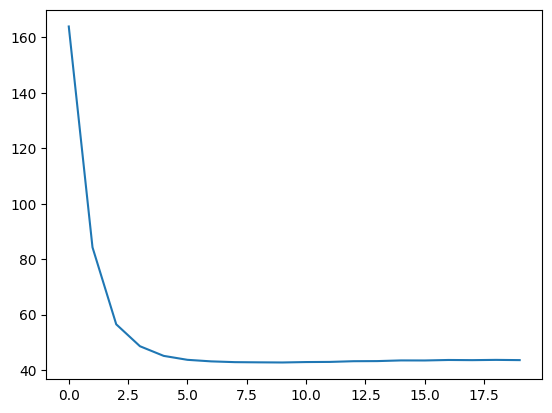

In [62]:
n_iter = 20
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history)
plt.show()

In [63]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [64]:
tokens

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [74]:
#get_embedding(model, 'word2vec')

In [78]:
#get_embedding(model, 'word')

In [79]:
#from sklearn.metrics.pairwise import cosine_similarity

In [80]:
#cosine_similarity(get_embedding(model, 'word2vec').reshape(1, -1), get_embedding(model, 'word').reshape(1, -1))